In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression


In [2]:
np.random.seed(42)

data = {
    "shop_id": np.random.randint(100, 110, 120),
    "beneficiary_id": np.random.randint(1000, 1100, 120),
    "beneficiaries_count": np.random.randint(30, 70, 120),
    "quantity_kg": np.random.randint(150, 350, 120)
}

df = pd.DataFrame(data)

# Inject abnormal/fraud cases
fraud_indices = np.random.choice(df.index, 20, replace=False)
df.loc[fraud_indices, "quantity_kg"] = np.random.randint(600, 1000, 20)

df.head()


,shop_id,beneficiary_id,beneficiaries_count,quantity_kg
0,106,1078,68,964
1,103,1014,47,157
2,107,1089,69,891
3,104,1041,30,291
4,106,1076,40,264


In [3]:
model = IsolationForest(contamination=0.17, random_state=42)
df["anomaly"] = model.fit_predict(df[["beneficiaries_count", "quantity_kg"]])
df["status"] = df["anomaly"].apply(lambda x: "Suspicious" if x == -1 else "Normal")


In [4]:
def explain_reason(row):
    if row["quantity_kg"] > row["beneficiaries_count"] * 7:
        return "Quantity unusually high for number of beneficiaries"
    elif row["quantity_kg"] > 500:
        return "Quantity exceeds safe distribution threshold"
    else:
        return "Normal distribution pattern"

df["reason"] = df.apply(explain_reason, axis=1)


In [5]:
def calculate_risk(row):
    risk = (row["quantity_kg"] / (row["beneficiaries_count"] * 5)) * 50
    if row["status"] == "Suspicious":
        risk += 30
    return min(int(risk), 100)

df["risk_score"] = df.apply(calculate_risk, axis=1)


In [6]:
suspicious_shops = df[df["status"] == "Suspicious"]["shop_id"].unique()
print("Suspicious Shops:", suspicious_shops)


Suspicious Shops: [106 107 104 109 103 105 101 108 100 102]


In [7]:
top_5_shops = (
    df[df["status"] == "Suspicious"]
    .groupby("shop_id")
    .size()
    .sort_values(ascending=False)
    .head(5)
)
print("Top 5 Problematic Shops:")
print(top_5_shops)


Top 5 Problematic Shops:
shop_id
107    6
106    4
101    2
100    2
104    2
dtype: int64


In [8]:
threshold_alerts = df[df["quantity_kg"] > 700]
print("Threshold Alerts (quantity > 700kg):")
print(threshold_alerts[["shop_id","beneficiary_id","quantity_kg","risk_score"]])


Threshold Alerts (quantity > 700kg):
     shop_id  beneficiary_id  quantity_kg  risk_score
0        106            1078          964         100
2        107            1089          891         100
5        109            1050          938         100
10       103            1003          816         100
14       105            1042          721         100
17       107            1012          735         100
37       106            1088          900         100
38       101            1061          851         100
41       101            1026          941         100
65       109            1038          882         100
82       107            1043          793         100
84       107            1031          764         100
87       100            1067          874         100
89       102            1074          744         100
99       107            1015          926         100
109      102            1035          920         100
114      100            1019          731    

In [9]:
beneficiary_risk = (
    df[df["status"] == "Suspicious"]
    .groupby("beneficiary_id")
    .size()
    .reset_index(name="suspicious_count")
)
suspicious_beneficiaries = beneficiary_risk[beneficiary_risk["suspicious_count"] > 3]
print("Suspicious Beneficiaries (>3 suspicious txns):")
print(suspicious_beneficiaries)


Suspicious Beneficiaries (>3 suspicious txns):
Empty DataFrame
Columns: [beneficiary_id, suspicious_count]
Index: []


In [10]:
X = df[["beneficiaries_count"]]
y = df["quantity_kg"]

reg_model = LinearRegression()
reg_model.fit(X, y)

future_beneficiaries = np.array([[50]])  # example
predicted_quantity = reg_model.predict(future_beneficiaries)
print("Predicted future quantity for 50 beneficiaries:", int(predicted_quantity[0]), "kg")

if predicted_quantity[0] > 500:
    print("⚠ Future anomaly risk detected")
else:
    print("✅ Future distribution looks normal")


Predicted future quantity for 50 beneficiaries: 333 kg
✅ Future distribution looks normal


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


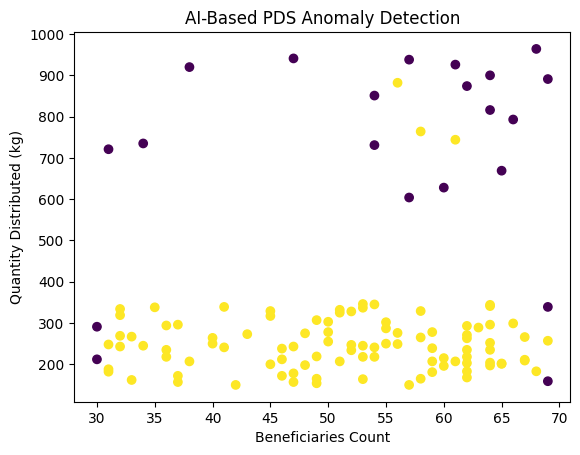

In [11]:
plt.scatter(df["beneficiaries_count"], df["quantity_kg"], c=df["anomaly"])
plt.xlabel("Beneficiaries Count")
plt.ylabel("Quantity Distributed (kg)")
plt.title("AI-Based PDS Anomaly Detection")
plt.show()


In [12]:
df[["shop_id","beneficiary_id","beneficiaries_count","quantity_kg","status","risk_score","reason"]].head(10)


,shop_id,beneficiary_id,beneficiaries_count,quantity_kg,status,risk_score,reason
0,106,1078,68,964,Suspicious,100,Quantity unusually high for number of benefici...
1,103,1014,47,157,Normal,33,Normal distribution pattern
2,107,1089,69,891,Suspicious,100,Quantity unusually high for number of benefici...
3,104,1041,30,291,Suspicious,100,Quantity unusually high for number of benefici...
4,106,1076,40,264,Normal,66,Normal distribution pattern
5,109,1050,57,938,Suspicious,100,Quantity unusually high for number of benefici...
6,102,1062,54,241,Normal,44,Normal distribution pattern
7,106,1095,52,247,Normal,47,Normal distribution pattern
8,107,1051,60,215,Normal,35,Normal distribution pattern
9,104,1095,59,181,Normal,30,Normal distribution pattern


In [13]:
# Save suspicious shops
pd.DataFrame(suspicious_shops, columns=["shop_id"]).to_csv("suspicious_shops.csv", index=False)

# Save suspicious beneficiaries
pd.DataFrame(suspicious_beneficiaries, columns=["beneficiary_id"]).to_csv("suspicious_beneficiaries.csv", index=False)

# Save full dataset
df.to_csv("pds_data.csv", index=False)


In [ ]:
from flask import Flask, jsonify

app = Flask(__name__)

@app.route("/")
def home():
    return "PDS Monitoring Backend running"

@app.route("/suspicious_shops")
def suspicious_shops_api():
    return jsonify(suspicious_shops)

@app.route("/suspicious_beneficiaries")
def suspicious_beneficiaries_api():
    return jsonify(suspicious_beneficiaries)

@app.route("/future_prediction")
def future_prediction_api():
    return jsonify({
        "predicted_quantity": float(future_quantity)
    })

app.run(port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
